# Comparing Uncertainties on Ackley 2D/5D

Code for repeated runs on the cluster: See `runs/2021-07-11.sh`.

In [1]:
from exp_sim_optim_simple import (
    setup_objective,
    run_sim_optim_gp,
    run_sim_optim_torch,
    run_sim_optim_tf2,
    run_sim_optim_mcd_tf2,
    plot_regrets,
    plot_surface,
    plot_acq,
    plot_pointwise_acq,
    plot_sigs,
)

import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import tensorflow as tf
import GPyOpt

In [2]:
print("torch:", torch.__version__)
print("tensorflow:", tf.__version__)

%matplotlib inline
plt.style.use("seaborn-notebook")
colors = sns.color_palette()

torch: 1.7.1
tensorflow: 2.4.1


## Problem: Finding Minimum of the Ackley Function

In [3]:
# Common arguments
# input_dim = 2
# max_iter = 100
# layer_sizes = [8, 8, 4]
input_dim = 5
max_iter = 200
layer_sizes = [16, 16, 8]
learning_rate = 0.01
weight_decay = 1e-5
dropout = 0.0
init_points = 10

plots_dir = f"results/uncertainty_ackley{input_dim}d" + (f"_wd{weight_decay}" if weight_decay > 0.0 else "")
os.makedirs(plots_dir, exist_ok=True)

In [4]:
problem, domain = setup_objective(
    "Ackley", 
    input_dim,
)

## Baseline: GP-LCB

In [5]:
# ~45 seconds on laptop
gp_opt = run_sim_optim_gp(
    problem,
    domain,
    max_iter=max_iter,
    acquisition_type="LCB",
    acquisition_optimizer_type="lbfgs",  # default
    init_points=init_points,
    normalize_Y=True,
    verbosity=False,
)

minimum: 2.276405127981084
minimizer: [-0.24540767 -0.16661892  0.4084201  -0.08749367 -0.05860669]
μ(x*): -2.0894071395489844
σ(x*): 0.026680210851138746
elapsed time: 134.79 seconds


In [6]:
gp_opt.plot_acquisition()

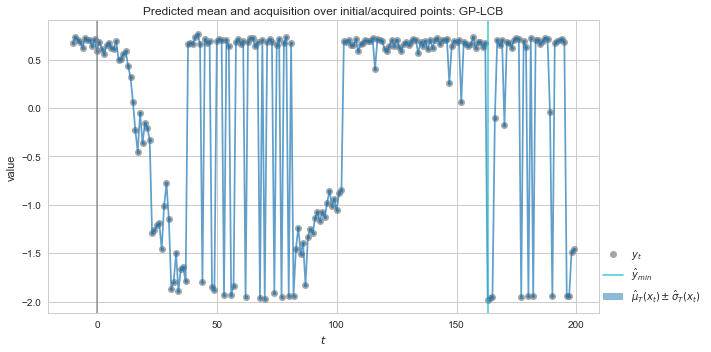

In [7]:
plot_pointwise_acq(gp_opt, normalize_Y=True, name="GP-LCB",
                   plot_filename=os.path.join(plots_dir, f"pointwise_acq_gplcb.pdf"))

## NN-INF (Adam Acq.)

In [8]:
nninf = run_sim_optim_torch(
    problem,
    domain,
    layer_sizes=layer_sizes,
    dropout=dropout,
    max_iter=max_iter,
    init_points=init_points,
    nn_optim_params={"lr": learning_rate, "weight_decay": weight_decay},
    # update_iters_per_point=1,
)

Optimizing:   0%|          | 0/200 [00:00<?, ?it/s]

FCNet(
  (fc_0): Linear(in_features=5, out_features=16, bias=True)
  (fc_1): Linear(in_features=16, out_features=16, bias=True)
  (fc_2): Linear(in_features=16, out_features=8, bias=True)
  (fc_last): Linear(in_features=8, out_features=1, bias=True)
  (scale): Linear(in_features=1, out_features=1, bias=True)
)
Models printout after each iteration is only available for GP and GP_MCMC models


Optimizing: 100%|██████████| 200/200 [00:45<00:00,  4.38it/s, R_i=17.2, exp_w=82, f*hat=17.2, fhat_i=21, r_i=21, t_i=0.235, y_i=21, α(x*)=-97.1, α*=-99.9, μ(x*)=20.5, μ*=21, σ(x*)=1.43, σ*=1.47]            

Elapsed Time: 45.65s
predicted minimum value: 21.048112869262695 +/- 1.6954423189163208
predicted minimizer: [  3.45149994   2.74246621 -12.48704433   5.45743799   5.72084093]
actual value at predicted minimizer: 17.150941848754883


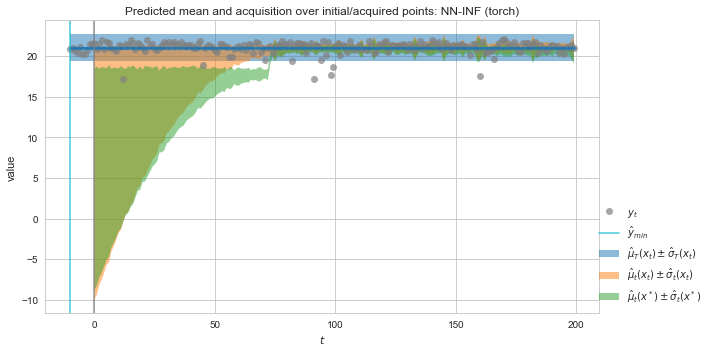

In [9]:
plot_pointwise_acq(nninf["bo"], normalize_Y=False, 
                   result_dict=nninf, name="NN-INF (torch)",
                   plot_filename=os.path.join(plots_dir, f"pointwise_acq_nninf.pdf"))

In [10]:
ys, vs = nninf["bo"].model.predict(nninf["bo"].X)
ys[-1].item(), ys.min()

(21.048112869262695, 21.048113)

## NN-INF (Greedy)

In [11]:
nninf_greedy = run_sim_optim_torch(
    problem,
    domain,
    layer_sizes=layer_sizes,
    dropout=dropout,
    max_iter=max_iter,
    init_points=init_points,
    nn_optim_params={"lr": learning_rate, "weight_decay": weight_decay},
    # update_iters_per_point=1,
    use_const_exp_w=0.0,
)

Optimizing:   0%|          | 0/200 [00:00<?, ?it/s]

FCNet(
  (fc_0): Linear(in_features=5, out_features=16, bias=True)
  (fc_1): Linear(in_features=16, out_features=16, bias=True)
  (fc_2): Linear(in_features=16, out_features=8, bias=True)
  (fc_last): Linear(in_features=8, out_features=1, bias=True)
  (scale): Linear(in_features=1, out_features=1, bias=True)
)
Models printout after each iteration is only available for GP and GP_MCMC models


Optimizing: 100%|██████████| 200/200 [00:41<00:00,  4.83it/s, R_i=15.5, exp_w=0, f*hat=15.5, fhat_i=21.3, r_i=21.3, t_i=0.19, y_i=21.3, α(x*)=21, α*=21, μ(x*)=21, μ*=21, σ(x*)=0.714, σ*=0.714]         

Elapsed Time: 41.40s
predicted minimum value: 21.030677795410156 +/- 0.5820896029472351
predicted minimizer: [-6.23925972 -0.81965959  7.69956493  8.33727837 -2.14318109]
actual value at predicted minimizer: 15.492839813232422


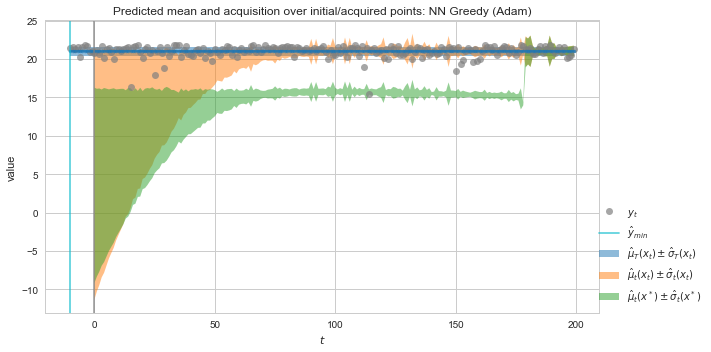

In [12]:
plot_pointwise_acq(nninf_greedy["bo"], normalize_Y=False, 
                   result_dict=nninf_greedy, name="NN Greedy (Adam)",
                   plot_filename=os.path.join(plots_dir, f"pointwise_acq_nngreedy.pdf"))

In [13]:
ys, vs = nninf_greedy["bo"].model.predict(nninf_greedy["bo"].X)
ys[-1].item(), ys.min()

(21.030677795410156, 21.030678)

## NN-INF (TF2)

In [14]:
nninf_tf2 = run_sim_optim_tf2(
    problem,
    domain,
    layer_sizes=layer_sizes,
    dropout=dropout,
    max_iter=max_iter,
    init_points=init_points,
    nn_optim_params={"learning_rate": learning_rate},
    weight_decay=weight_decay,
)

Optimizing:   0%|          | 0/200 [00:00<?, ?it/s]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 16)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________
Models printout after each iteration is only available for GP and GP_MCMC models


Optimizing: 100%|██████████| 200/200 [10:48<00:00,  3.24s/it, R_i=0.88, exp_w=82, f*hat=0.88, fhat_i=20.3, r_i=20.3, t_i=1.42, y_i=20.3, α(x*)=2.26, α*=15.8, μ(x*)=2.28, μ*=20.8, σ(x*)=0.000263, σ*=0.06]        

Elapsed Time: 648.02s
predicted minimum value: 2.2864162921905518 +/- 0.0003083472838625312
predicted minimizer: [-0.02253392  0.12145288  0.163293   -0.06828854  0.07303734]
actual value at predicted minimizer: 0.8797781467437744


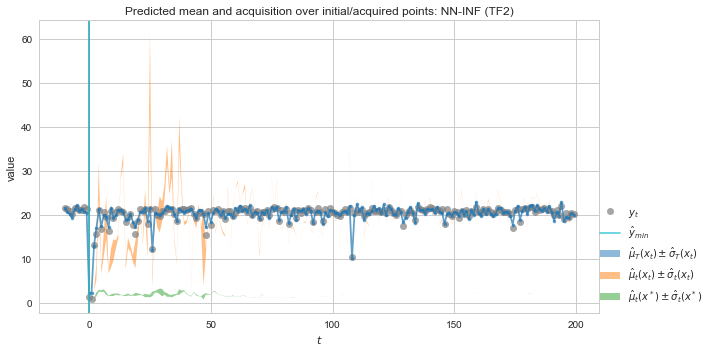

In [15]:
plot_pointwise_acq(nninf_tf2["bo"], normalize_Y=False, 
                   result_dict=nninf_tf2, name="NN-INF (TF2)",
                   plot_filename=os.path.join(plots_dir, f"pointwise_acq_nninf_tf2.pdf"))

In [16]:
ys, vs = nninf_tf2["bo"].model.predict(nninf_tf2["bo"].X)
ys[-1].item(), ys.min()

(20.094629287719727, 2.2864163)

## NN-MCD (TF2)

In [17]:
nninf_mcd_tf2 = run_sim_optim_mcd_tf2(
    problem,
    domain,
    layer_sizes=layer_sizes,
    dropout=0.1,
    max_iter=max_iter,
    init_points=init_points,
    nn_optim_params={"learning_rate": learning_rate},
    weight_decay=weight_decay,
)

Optimizing:   0%|          | 0/200 [00:00<?, ?it/s]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 5)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                96        
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                

Optimizing: 100%|██████████| 200/200 [10:49<00:00,  3.25s/it, R_i=4.55, exp_w=82, f*hat=4.55, fhat_i=21.5, r_i=21.5, t_i=1.93, y_i=21.5, α(x*)=-151, α*=-161, μ(x*)=18.7, μ*=20.7, σ(x*)=2.07, σ*=2.24]    

Elapsed Time: 649.82s
predicted minimum value: 18.519502639770508 +/- 2.073504686355591
predicted minimizer: [-0.6628679   0.97644454 -1.18991208  0.35632131  0.25711346]
actual value at predicted minimizer: 4.554177284240723


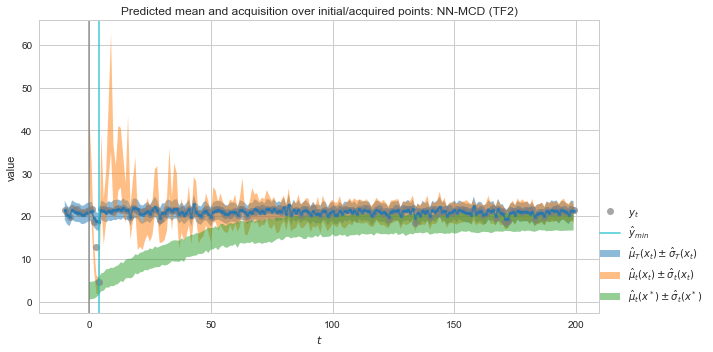

In [18]:
plot_pointwise_acq(nninf_mcd_tf2["bo"], normalize_Y=False, 
                   result_dict=nninf_mcd_tf2, name="NN-MCD (TF2)",
                   plot_filename=os.path.join(plots_dir, f"pointwise_acq_nnmcd_tf2.pdf"))

In [19]:
ys, vs = nninf_mcd_tf2["bo"].model.predict(nninf_mcd_tf2["bo"].X)
ys[-1].item(), ys.min()

(21.206518173217773, 18.578957)

## Combined Results

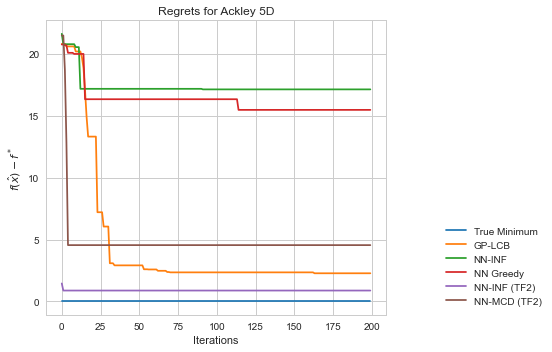

In [20]:
plot_regrets(
    [np.repeat(0, max_iter), 
     gp_opt.Y_best[-max_iter:] - problem.fmin, 
     nninf["regrets"],
     nninf_greedy["regrets"],
     nninf_tf2["regrets"],
     nninf_mcd_tf2["regrets"],
    ],
    problem.name, 
    ["True Minimum", "GP-LCB", "NN-INF", "NN Greedy", "NN-INF (TF2)", "NN-MCD (TF2)"],
    plot_filename=os.path.join(plots_dir, f"regrets.pdf"),
)

In [21]:
# NN Surface
if input_dim == 2:
    minimizers = [
        (problem.min, problem.fmin, "True Minimum"),
        (gp_opt.x_opt, gp_opt.fx_opt, "GP-LCB"),
        (nninf["bo"].x_opt, nninf["bo"].fx_opt, "NN-INF"),
        (nninf_greedy["bo"].x_opt, nninf_greedy["bo"].fx_opt, "NN Greedy"),
        (nninf_tf2["bo"].x_opt, nninf_tf2["bo"].fx_opt, "NN-INF (TF2)"),
        (nninf_mcd_tf2["bo"].x_opt, nninf_mcd_tf2["bo"].fx_opt, "NN-MCD (TF2)"),
    ]
    plot_surface(problem, problem.bounds[0][1], minimizers, problem.name,
                 plot_filename=os.path.join(plots_dir, f"surface.pdf"))

## Uncertainty

acquired: DescribeResult(nobs=210, minmax=(array([5.99536134e-05]), array([0.00010954])), mean=array([0.00010816]), variance=array([4.96993597e-11]), skewness=array([-5.32674642]), kurtosis=array([27.65791679]))
random: DescribeResult(nobs=210, minmax=(array([0.61608906]), array([0.64696222])), mean=array([0.64681147]), variance=array([4.53897622e-06]), skewness=array([-14.38166607]), kurtosis=array([204.88945581]))
near minimum: DescribeResult(nobs=210, minmax=(array([0.02015755]), array([0.24831851])), mean=array([0.12378969]), variance=array([0.0020603]), skewness=array([0.20556255]), kurtosis=array([-0.30916512]))


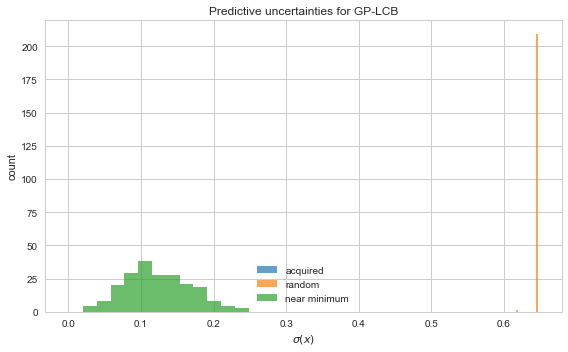

In [22]:
plot_sigs(gp_opt, "GP-LCB", 
          plot_filename=os.path.join(plots_dir, f"uncertainty_gplcb.pdf"))

acquired: DescribeResult(nobs=210, minmax=(array([1.69544232]), array([1.69544232])), mean=array([1.69544232]), variance=array([0.]), skewness=array([0.]), kurtosis=array([-3.]))
random: DescribeResult(nobs=210, minmax=(array([1.69544232]), array([1.69544232])), mean=array([1.69544232]), variance=array([0.]), skewness=array([0.]), kurtosis=array([-3.]))
near minimum: DescribeResult(nobs=210, minmax=(array([1.64300811]), array([1.69451106])), mean=array([1.67792386]), variance=array([0.0001357]), skewness=array([-0.73947106]), kurtosis=array([-0.07576771]))


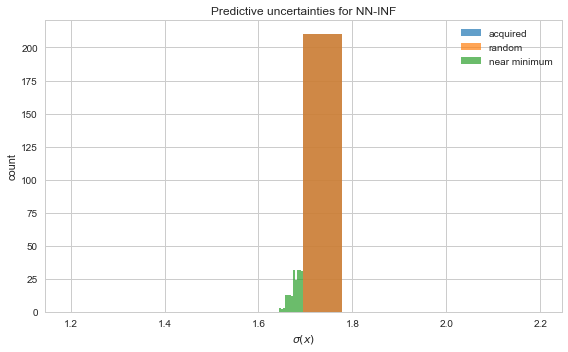

In [23]:
plot_sigs(nninf["bo"], "NN-INF",
          plot_filename=os.path.join(plots_dir, f"uncertainty_nninf.pdf"))

acquired: DescribeResult(nobs=210, minmax=(array([0.5820896]), array([0.5820896])), mean=array([0.5820896]), variance=array([0.]), skewness=array([0.]), kurtosis=array([-3.]))
random: DescribeResult(nobs=210, minmax=(array([0.5820896]), array([0.5820896])), mean=array([0.5820896]), variance=array([0.]), skewness=array([0.]), kurtosis=array([-3.]))
near minimum: DescribeResult(nobs=210, minmax=(array([0.58073843]), array([0.5820896])), mean=array([0.58203268]), variance=array([2.19131126e-08]), skewness=array([-5.44362828]), kurtosis=array([36.33134226]))


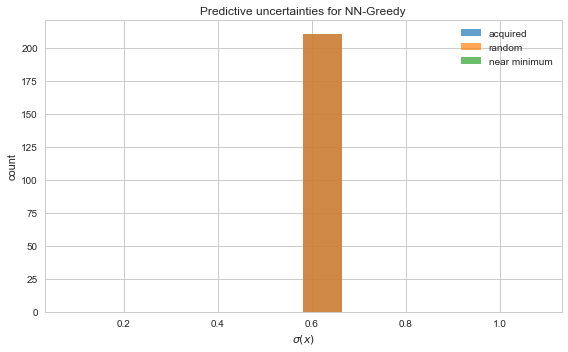

In [24]:
plot_sigs(nninf_greedy["bo"], "NN-Greedy",
          plot_filename=os.path.join(plots_dir, f"uncertainty_nngreedy.pdf"))

acquired: DescribeResult(nobs=210, minmax=(array([0.00030835]), array([0.12223098])), mean=array([0.04654134]), variance=array([0.00040754]), skewness=array([0.87644015]), kurtosis=array([0.92453346]))
random: DescribeResult(nobs=210, minmax=(array([0.02016145]), array([0.11340168])), mean=array([0.0522676]), variance=array([0.00039364]), skewness=array([0.95099838]), kurtosis=array([0.63896448]))
near minimum: DescribeResult(nobs=210, minmax=(array([0.00030835]), array([0.0194676])), mean=array([0.00602856]), variance=array([5.09626149e-05]), skewness=array([0.60876949]), kurtosis=array([-1.38410331]))


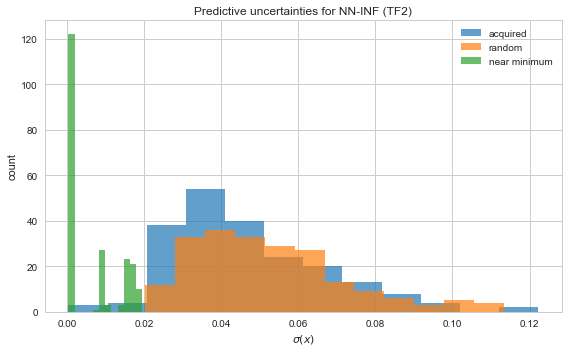

In [25]:
plot_sigs(nninf_tf2["bo"], "NN-INF (TF2)",
          plot_filename=os.path.join(plots_dir, f"uncertainty_nninf_tf2.pdf"))

acquired: DescribeResult(nobs=210, minmax=(array([2.05091667]), array([2.43627524])), mean=array([2.21018328]), variance=array([0.00365918]), skewness=array([0.45043906]), kurtosis=array([0.89599775]))
random: DescribeResult(nobs=210, minmax=(array([2.08800983]), array([2.36412835])), mean=array([2.18851248]), variance=array([0.00249128]), skewness=array([0.53963329]), kurtosis=array([0.08621109]))
near minimum: DescribeResult(nobs=210, minmax=(array([2.03929138]), array([2.09780455])), mean=array([2.05972422]), variance=array([0.00012881]), skewness=array([0.59894138]), kurtosis=array([0.27309828]))


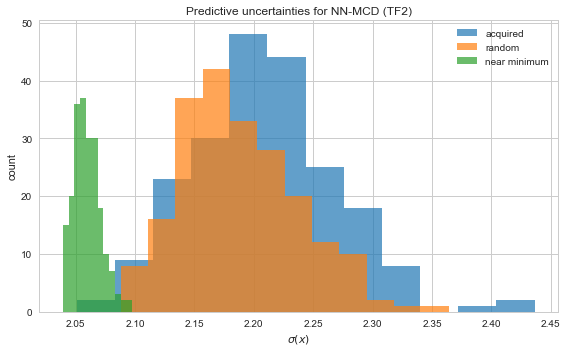

In [26]:
plot_sigs(nninf_mcd_tf2["bo"], "NN-MCD (TF2)",
          plot_filename=os.path.join(plots_dir, f"uncertainty_nnmcd_tf2.pdf"))